In [1]:
# 加载模块
from torch.optim import lr_scheduler

假设数据集中的观测特征变量和观测标签对应的自然特征变量和自然标签之间的关系为: $y = 2x_1^2 - x_2^2 + 3x_3^2 + x_4^2 + 2x_5^2$

In [16]:
# 加载数据
torch.manual_seed(420)

# 加载原始的数据集
X, y = tensorGenReg(w=[2, -1, 3, 1, 2], bias=False, degree=2)

# 如果深度神经网络模型需要学习的数据集的特征变量和标签是分开存储的, 则先将特征变量和标签按照样本的编号进行合并(Dataset, TorchDataset或者自定义集成Dataset的类)
# 对于合并后的完整的数据集, 先根据指定的比例将其划分为训练数据集和测试数据集(torch.utils.data.random_split)
# 再根据指定的样本容量将训练数据集和测试数据集分别划分为若干个互不相交的子数据集(DataLoader)
dataset_train, dataset_test = split_loader(X=X, y=y)

In [3]:
# 搭建模型: 使用面向对象(定义类/创建对象)的方式 继承nn.Module类
class net_class2(nn.Module):
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, hidden_features=[4, 4], out_features=1, bias=True, act_fun=torch.relu, BN_mode=None, momentum=0.1):
        super(net_class2, self).__init__()

        self.hidden1_linear = nn.Linear(in_features=in_features, out_features=hidden_features[0], bias=bias)
        self.hidden1_bn1d = nn.BatchNorm1d(num_features=hidden_features[0], momentum=momentum)
        
        self.hidden2_linear = nn.Linear(in_features=hidden_features[0], out_features=hidden_features[1], bias=bias)
        self.hidden2_bn1d = nn.BatchNorm1d(num_features=hidden_features[1], momentum=momentum)
        
        self.output_linear = nn.Linear(in_features=hidden_features[1], out_features=out_features, bias=bias)
        self.BN_mode = BN_mode
        self.act_fun = act_fun
        
    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        if self.BN_mode == None:
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层不工作) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第三层 -> 隐藏层第四层(数据归一化层不工作) -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma)
            
        elif self.BN_mode == 'before':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            zhat_norm = self.hidden1_bn1d(zhat)       
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            zhat_norm = self.hidden2_bn1d(zhat)
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层等三层 -> 输出层
            zhat = self.output_linear(sigma)
        
        elif self.BN_mode == 'after':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            sigma_norm = self.hidden1_bn1d(sigma)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma_norm)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 调整分布
            sigma_norm = self.hidden2_bn1d(sigma)

            # 隐藏层第三层 -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma_norm)
        return zhat

In [4]:
# 搭建模型: 使用面向对象(定义类/创建对象)的方式 继承nn.Module类
class net_class3(nn.Module):
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, hidden_features=[4, 4, 4], out_features=1, bias=True, act_fun=torch.relu, BN_mode=None, momentum=0.1):
        super(net_class3, self).__init__()

        self.hidden1_linear = nn.Linear(in_features=in_features, out_features=hidden_features[0], bias=bias)
        self.hidden1_bn1d = nn.BatchNorm1d(num_features=hidden_features[0], momentum=momentum)
        
        self.hidden2_linear = nn.Linear(in_features=hidden_features[0], out_features=hidden_features[1], bias=bias)
        self.hidden2_bn1d = nn.BatchNorm1d(num_features=hidden_features[1], momentum=momentum)

        self.hidden3_linear = nn.Linear(in_features=hidden_features[1], out_features=hidden_features[2], bias=bias)
        self.hidden3_bn1d = nn.BatchNorm1d(num_features=hidden_features[2], momentum=momentum)
        
        self.output_linear = nn.Linear(in_features=hidden_features[2], out_features=out_features, bias=bias)
        self.BN_mode = BN_mode
        self.act_fun = act_fun
        
    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        if self.BN_mode == None:
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第一层 -> 隐藏层第二层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第二层 -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden3_linear(sigma)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第三层 -> 输出层
            zhat = self.output_linear(sigma)
            
        elif self.BN_mode == 'before':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 在加工信息之前调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            zhat_norm = self.hidden1_bn1d(zhat)       
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层第一层 -> 隐藏层第二层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 在加工信息之前调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            zhat_norm = self.hidden2_bn1d(zhat)
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层第二层 -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden3_linear(sigma)
            # 在加工信息之前调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            zhat_norm = self.hidden3_bn1d(zhat)
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层第三层 -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma)
            
        elif self.BN_mode == 'after':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 在加工信息之后调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            sigma_norm = self.hidden1_bn1d(sigma)

            # 隐藏层第一层 -> 隐藏层第二层
            # 整合信息
            zhat = self.hidden2_linear(sigma_norm)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 在加工信息之后调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            sigma_norm = self.hidden2_bn1d(sigma)

            # 隐藏层第二层 -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden3_linear(sigma_norm)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 在加工信息之后调整整合信息得到的当前batch的各个中间潜在变量的均值和方差
            sigma_norm = self.hidden3_bn1d(sigma)

            # 隐藏层第三层 -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma_norm)
        return zhat

In [4]:
# 加载模型
torch.manual_seed(24)

tanh_model1 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [5]:
# 选择合适的优化器
optimizer = optim.SGD(params=tanh_model1.parameters(), lr=0.01)

In [6]:
# 查看当前优化器的状态
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [7]:
optimizer.state_dict()["param_groups"]

[{'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

In [8]:
optimizer.state_dict()["param_groups"][0]

{'lr': 0.01,
 'momentum': 0,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False,
 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [9]:
optimizer.state_dict()["param_groups"][0]["lr"]

0.01

In [10]:
list(tanh_model1.parameters())

[Parameter containing:
 tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
         [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
         [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
         [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]], requires_grad=True),
 Parameter containing:
 tensor([-0.3999, -0.2694,  0.2703, -0.3355], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
         [ 0.2336, -0.3569, -0.1928, -0.1566],
         [ 0.4825, -0.4463,  0.3027,  0.4696],
         [ 0.3953,  0.2131,  0.2226, -0.0267]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2516,  0.4558, -0.1608,  0.4831], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.07

In [11]:
len(list(tanh_model1.parameters()))

10

In [13]:
tanh_model2 = net_class3(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [14]:
# 选择合适的优化器
optimizer2 = optim.SGD(params=tanh_model2.parameters(), lr=0.05)

In [15]:
optimizer2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

In [16]:
len(list(tanh_model2.parameters()))

14

In [17]:
torch.manual_seed(24)

tanh_model1 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [18]:
tanh_model1.state_dict()

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.bias', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_mean', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_var', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.num_batches_tracked', tensor(0)),
             ('hidden2_linear.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.213

In [19]:
len(tanh_model1.state_dict())

16

In [20]:
model_params = tanh_model1.state_dict()
model_params

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.bias', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_mean', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_var', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.num_batches_tracked', tensor(0)),
             ('hidden2_linear.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.213

##### 将存储在计算机的内存中的数据 转存在 计算机的外存(disk,磁盘)中 以文件的形式存储

In [21]:
torch.save(obj=tanh_model1.state_dict(), f="tanh_model1.pt")

In [23]:
# 选择合适的损失函数
criterion = nn.MSELoss()
# 选择合适的优化器
optimizer = optim.SGD(params=tanh_model1.parameters(), lr=0.05)

In [24]:
# 搭建深度神经网络模型的训练流程: 学习完整的训练数据集 一遍
for (i_X, i_y) in dataset_train:
    # 前向传播: 计算模型对于数据集的预测输出标记
    yhat = tanh_model1.forward(i_X)
    # 计算损失: 计算模型的预测输出标记与真实标签之间的误差并且构建完整的计算图
    loss = criterion(yhat, i_y)
    # 清空当前计算图中各个模型的参数对应的偏导函数的计算结果
    optimizer.zero_grad()
    # 反向传播: 计算当前计算图中各个模型的参数对应的偏导函数表达式在当前模型的参数取值时的偏导函数值
    loss.backward()
    # 更新参数: 优化器根据计算的梯度信息, 按照自身设置的更新规则调整全部模型的参数
    optimizer.step()

In [25]:
# 查看当前模型的全部参数
tanh_model1.state_dict()

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.6052, -0.2510, -0.0355,  0.1557,  0.7310],
                      [-0.4274, -0.4063,  0.4120,  0.0307, -0.5042],
                      [ 1.0108, -0.1022, -0.6386, -0.2919,  0.4678],
                      [ 0.1771,  0.1991, -0.3995, -0.1528, -0.8841]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1.1514, 1.0006, 1.1225, 1.0267])),
             ('hidden1_bn1d.bias',
              tensor([-0.1697,  0.1586, -0.5973, -0.4330])),
             ('hidden1_bn1d.running_mean',
              tensor([-0.3651, -0.2951,  0.2109, -0.5283])),
             ('hidden1_bn1d.running_var',
              tensor([0.9744, 0.6897, 1.7492, 1.0106])),
             ('hidden1_bn1d.num_batches_tracked', tensor(70)),
             ('hidden2_linear.weight',
              tensor([[ 0.1620,  0.6879, -0.1934, -0.1791],
                      [ 0.2927, -0.3718, -0

In [26]:
model_params

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.6052, -0.2510, -0.0355,  0.1557,  0.7310],
                      [-0.4274, -0.4063,  0.4120,  0.0307, -0.5042],
                      [ 1.0108, -0.1022, -0.6386, -0.2919,  0.4678],
                      [ 0.1771,  0.1991, -0.3995, -0.1528, -0.8841]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1.1514, 1.0006, 1.1225, 1.0267])),
             ('hidden1_bn1d.bias',
              tensor([-0.1697,  0.1586, -0.5973, -0.4330])),
             ('hidden1_bn1d.running_mean',
              tensor([-0.3651, -0.2951,  0.2109, -0.5283])),
             ('hidden1_bn1d.running_var',
              tensor([0.9744, 0.6897, 1.7492, 1.0106])),
             ('hidden1_bn1d.num_batches_tracked', tensor(70)),
             ('hidden2_linear.weight',
              tensor([[ 0.1620,  0.6879, -0.1934, -0.1791],
                      [ 0.2927, -0.3718, -0

In [27]:
# 将存储在计算机的外存中的文件 加载到 计算机的内存中
torch.load(f="tanh_model1.pt")

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.bias', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_mean', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_var', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.num_batches_tracked', tensor(0)),
             ('hidden2_linear.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.213

In [28]:
# 将当前模型架构中的所有参数更新为参数文件中的参数值
tanh_model1.load_state_dict(state_dict=torch.load(f="tanh_model1.pt"))

<All keys matched successfully>

In [29]:
tanh_model1.state_dict()

OrderedDict([('hidden1_linear.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('hidden1_linear.bias',
              tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('hidden1_bn1d.weight', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.bias', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_mean', tensor([0., 0., 0., 0.])),
             ('hidden1_bn1d.running_var', tensor([1., 1., 1., 1.])),
             ('hidden1_bn1d.num_batches_tracked', tensor(0)),
             ('hidden2_linear.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.213

##### 普通函数

In [30]:
def func(epoch):
    """对epoch的数值进行变换
    @param epoch: 对完整的训练数据集学习的遍数
    """
    return 0.5 ** epoch

##### 匿名函数 或 lambda表达式

In [31]:
# lambda关键字
lr_lambda = lambda epoch: 0.5 ** epoch

In [32]:
lr_lambda(epoch=0)

1.0

In [33]:
lr_lambda(epoch=1)

0.5

In [34]:
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

# 选择合适的优化器
optimizer = optim.SGD(params=tanh_model1.parameters(), lr=0.05)

In [35]:
# 查看优化器的状态
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [36]:
# 选择合适的学习率调度员, 按照给定的调度方案随着epoch动态调整学习率的取值
lr_dispatcher = lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)

In [37]:
# 查看优化器的状态
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [38]:
# 搭建深度神经网络模型的训练流程: 学习完整的训练数据集 一遍
for (i_X, i_y) in dataset_train:
    # 前向传播: 计算模型对于数据集的预测输出标记
    yhat = tanh_model1.forward(i_X)
    # 计算损失: 计算模型的预测输出标记与真实标签之间的误差并且构建完整的计算图
    loss = criterion(yhat, i_y)
    # 清空当前计算图中各个模型的参数对应的偏导函数的计算结果
    optimizer.zero_grad()
    # 反向传播: 计算当前计算图中各个模型的参数对应的偏导函数表达式在当前模型的参数取值时的偏导函数值
    loss.backward()
    # 更新参数: 优化器根据计算的梯度信息, 按照自身设置的更新规则调整全部模型的参数
    optimizer.step()
# 重点: 学习完整的训练数据集一遍之后, 要更新学习率调度器和epoch的关系
lr_dispatcher.step()

In [39]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.025,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [40]:
optimizer.zero_grad()
optimizer.step()
lr_dispatcher.step()

In [41]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.0125,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [42]:
lr_lambda(epoch=2) * 0.05

0.0125

In [43]:
lr_dispatcher.state_dict()

{'base_lrs': [0.05],
 'last_epoch': 2,
 'verbose': False,
 '_step_count': 3,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0125],
 'lr_lambdas': [None]}

In [46]:
# 选择一个合适的优化器
optimizer = optim.SGD(params=tanh_model1.parameters(), lr=0.05)

In [47]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

##### 先选择一个合适的优化器, 再选择一个合适的动态学习率调度器

In [48]:
# 动态的学习率调度器的学习率初始值应该和定义优化器时设置的初始值相等
# 选择一个合适的学习率动态调整公式, 与epoch有关. 即对训练数据集进行完整学习的遍数
lr_lambda = lambda epoch: 0.5 ** epoch
# 将学习率动态调整公式与优化器整合
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)

In [49]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [51]:
# 在计算机的内存中逐个存储多个数值 => 选择列表数据结构
lrs = []
n_epochs = 10
for i_epoch in range(n_epochs+1):
    lrs.append(lr_lambda(i_epoch) * 0.05)
lrs

[0.05,
 0.025,
 0.0125,
 0.00625,
 0.003125,
 0.0015625,
 0.00078125,
 0.000390625,
 0.0001953125,
 9.765625e-05,
 4.8828125e-05]

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'learning rate')

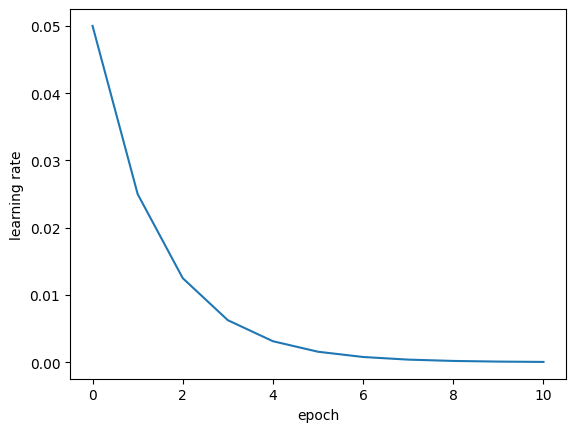

In [52]:
plt.plot(list(range(n_epochs+1)), lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.show()

In [53]:
# 在计算机的内存中逐个存储多个数值 => 选择列表数据结构
lrs = [0.05]
n_epochs = 10
for i_epoch in range(n_epochs):
    # 优化器根据梯度信息, 以给定的方式进行模型中全部参数的更新, 学习率是动态调整的
    optimizer.step()
    # 学习率调度器中同步记录当前完整学习训练数据集的遍数
    lr_scheduler.step()
    # 获取当前优化器中的学习率
    cur_lr = optimizer.state_dict()["param_groups"][0]["lr"]
    lrs.append(cur_lr)
lrs

[0.05,
 0.025,
 0.0125,
 0.00625,
 0.003125,
 0.0015625,
 0.00078125,
 0.000390625,
 0.0001953125,
 9.765625e-05,
 4.8828125e-05]

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'learning rate')

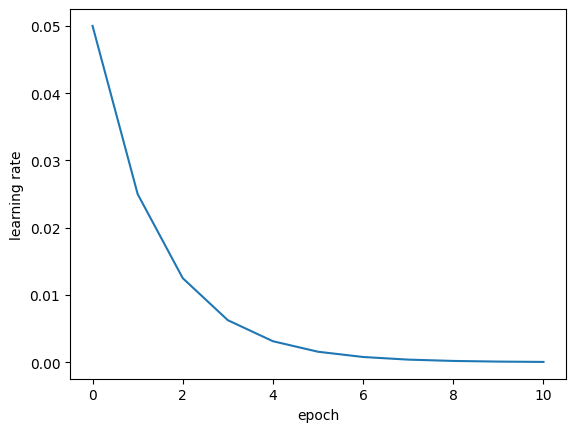

In [54]:
plt.plot(list(range(n_epochs+1)), lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.show()

In [5]:
lr_lambda = lambda epoch: 0.95 ** epoch

In [6]:
# 当第一次对训练数据集进行学习时, 优化器的学习率为
lr_lambda(epoch=0)

1.0

In [8]:
# 当第二次对训练数据集进行学习时, 优化器的学习率为
lr_lambda(epoch=1)

0.95

In [9]:
# ... 当第101次对训练数据集进行学习时, 优化器的学习率为
lr_lambda(epoch=100)

0.0059205292203339975

In [10]:
torch.manual_seed(24)

# 实例化模型, 完成模型参数的随机初始化
tanh_model1 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

##### 搭建一个深度神经网络模型的训练流程

In [11]:
# 选择合适的优化器
optimizer = optim.SGD(params=tanh_model1.parameters(), lr=0.05)

# 动态的学习率调度器的学习率初始值应该和定义优化器时设置的初始值相等
# 选择一个合适的学习率动态调整公式, 与epoch有关. 即对训练数据集进行完整学习的遍数
lr_lambda = lambda epoch: 0.95 ** epoch
# 将学习率动态调整公式与优化器整合
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)

##### 根据搭建的训练流程开始训练

In [17]:
losses_train, losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=60,
                                                 model=tanh_model1, criterion=nn.MSELoss(), optimizer=optimizer, scheduler=lr_scheduler,
                                                 task="reg", evaluation=calc_mse)

##### 绘制在引入动态学习率的训练过程中, 模型在训练数据集和测试数据集上的每一遍学习对应的模型性能评估指标

In [18]:
len(losses_train)

60

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

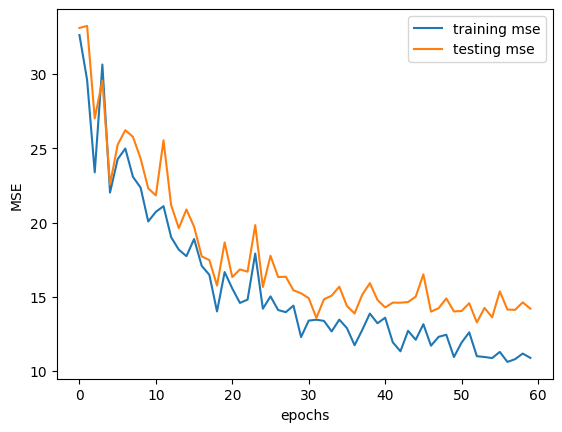

In [20]:
n_epochs = 60
plt.plot(list(range(n_epochs)), losses_train, label="training mse")
plt.plot(list(range(n_epochs)), losses_test, label="testing mse")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

In [21]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.002303489949347597,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [22]:
# 经过60轮迭代后, 如果还有第61轮对于训练数据集的训练, 则优化器的学习率是'lr': 0.002303489949347597
lr_lambda(epoch=60) * 0.05

0.002303489949347597